## Sentiment analysis - Amazon Health and Personal Care Reviews - Part 2
![](https://gitlab.com/sayantan.world98/sentiment-analysis-amazon-health-and-personal-care/-/raw/master/images/img1.jpg)

Sentiment analysis is the use of natural language processing, text analysis, computational linguistics, and biometrics to systematically identify, extract, quantify, and study affective states and subjective information.

We are using the **Amazon Health and Personal Care Reviews** dataset to perfom Sentiment Analysis. The dataset contains **346,355 reviews**.

Link to the original dataset source: http://jmcauley.ucsd.edu/data/amazon/

Find the project and dataset here: https://gitlab.com/sayantan.world98/sentiment-analysis-amazon-health-and-personal-care

Lets see what is there in our dataset.

Sample data
```
{
  "reviewerID": "A2SUAM1J3GNN3B",
  "asin": "0000013714",
  "reviewerName": "J. McDonald",
  "helpful": [2, 3],
  "reviewText": "I bought this for my husband who plays the piano.  He is having a wonderful time playing these old hymns.  The music  is at times hard to read because we think the book was published for singing from more than playing from.  Great purchase though!",
  "overall": 5.0,
  "summary": "Heavenly Highway Hymns",
  "unixReviewTime": 1252800000,
  "reviewTime": "09 13, 2009"
}
```
Where,

- reviewerID - ID of the reviewer, e.g. A2SUAM1J3GNN3B
- asin - ID of the product, e.g. 0000013714
- reviewerName - name of the reviewer
- helpful - helpfulness rating of the review, e.g. 2/3
- reviewText - text of the review
- overall - rating of the product
- summary - summary of the review
- unixReviewTime - time of the review (unix time)
- reviewTime - time of the review (raw)



### Sentiment Analysis using Word2Vec

**<font color='red'>Please read Part 1 before proceeding with this notebook.</font>**

![](https://gitlab.com/sayantan.world98/sentiment-analysis-amazon-health-and-personal-care/-/raw/master/images/word2vec.png)

Word2vec is a technique for natural language processing. The word2vec algorithm uses a neural network model to learn word associations from a large corpus of text. Once trained, such a model can detect synonymous words or suggest additional words for a partial sentence.

Word2Vec is one of the most popular technique to learn word embeddings using shallow neural network. It was developed by Tomas Mikolov in 2013 at Google.

The model uses Spacy (en_core_web_lg) as the Corpus.

spaCy is an open-source software library for advanced natural language processing, written in the programming languages Python and Cython. The library is published under the MIT license and its main developers are Matthew Honnibal and Ines Montani, the founders of the software company Explosion.

### Download and Import required libraries for Word2Vec

In [ ]:
!pip install spacy
!python -m spacy download en_core_web_lg
!python -m spacy download en_core_web_sm

In [2]:
import spacy

In [3]:
import en_core_web_lg
nlp = en_core_web_lg.load()

In [60]:
# DataFrame
import pandas as pd 

# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# nltk
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB


# Utility
import pandas as pd
import numpy as np 
import warnings
warnings.filterwarnings('ignore')
import re
import string
import pickle

In [4]:
# Example showing how similarity works
x = 'king man woman'
doc = nlp(x)

for token1 in doc:
  for token2 in doc:
    print(token1.text, token2.text, token1.similarity(token2))

king king 1.0
king man 0.4088461
king woman 0.26556593
man king 0.4088461
man man 1.0
man woman 0.7401745
woman king 0.26556593
woman man 0.7401745
woman woman 1.0


### Downloading the dataset

In [ ]:
!git clone https://gitlab.com/sayantan.world98/sentiment-analysis-amazon-health-and-personal-care.git

In [57]:
# Loading the dataset in a dataframe
df = pd.read_json('/content/sentiment-analysis-amazon-health-and-personal-care/dataset/Health_and_Personal_Care_5.json', lines=True)

In [58]:
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,ALC5GH8CAMAI7,159985130X,AnnN,"[1, 1]",This is a great little gadget to have around. ...,5,Handy little gadget,1294185600,"01 5, 2011"
1,AHKSURW85PJUE,159985130X,"AZ buyer ""AZ buyer""","[1, 1]",I would recommend this for a travel magnifier ...,4,Small & may need to encourage battery,1329523200,"02 18, 2012"
2,A38RMU1Y5TDP9,159985130X,"Bob Tobias ""Robert Tobias""","[75, 77]",What I liked was the quality of the lens and t...,4,Very good but not great,1275955200,"06 8, 2010"
3,A1XZUG7DFXXOS4,159985130X,Cat lover,"[56, 60]",Love the Great point light pocket magnifier! ...,4,great addition to your purse,1202428800,"02 8, 2008"
4,A1MS3M7M7AM13X,159985130X,Cricketoes,"[1, 1]",This is very nice. You pull out on the magnifi...,5,Very nice and convenient.,1313452800,"08 16, 2011"


**<font color='red'>To see the visualization of the Data Frame plese refer to Part 1</font>**

### Data Cleaning

We can see we have a lot of 5 star (positive) reviews compared to the negative ones. Lets consider: 
- 5 and 4 stared reviews as positive class(i.e class - 1).
- 1 and 2 stared reviews as negative class(i.e class - 0). 

As we have a biased dataset lets use 32,000 positive reviews and 32,000 negative reviews.

In [61]:
# We use this to give a weight to the helpful reviews and we also applied smoothing.
df['score'] = df.helpful.apply(lambda x: x[0] / (x[1] + 2))
df_pos = df[(df.overall == 5) | (df.overall == 4)]
df_pos = df_pos.sample(n=32000, weights=df.score, random_state=42)
df_neg = df[(df.overall == 2) | (df.overall == 1)]
df_neg = df_neg.sample(n=32000, random_state=42)

In [62]:
df_all = pd.concat([df_pos, df_neg])

In [64]:
# Positive class - 1, Negative class - 0
def sentiment_score(n):
  if n == 5 or n == 4:
    return 1
  return 0

df_all['overall']=df_all['overall'].apply(lambda x: sentiment_score(x))

In [65]:
df_all = df_all.drop(['reviewerName', 'helpful', 'unixReviewTime', 'reviewTime', 'score', 'summary', 'asin', 'reviewerID'], axis=1)

In [66]:
# Reset index
df_all.reset_index().drop(['index'], axis=1)

,reviewText,overall
0,"My stepdad needed a shower chair, and the ones...",1
1,It works. However it had a lot of bubbles ins...,1
2,We bought these for my 8 year old with high-fu...,1
3,I've owned a front-loader (HE) washing machine...,1
4,"Good value for use in the home; not too big, n...",1
...,...,...
63995,Picked up a pair of Duracell AA batteries on a...,0
63996,This dried up after only one or two sparse use...,0
63997,I had dislocated and broken my shoulder nearly...,0
63998,When I was a child I remember reading a short ...,0


In [67]:
# 64k reviews - Takes around 7 mins to get cleaned
df_all['cleaned_reviews'] = df_all['reviewText'].apply(lambda x: get_clean(x))

In [68]:
def get_vec(x):
  doc = nlp(x)
  vec = doc.vector
  return vec

In [69]:
df_all

,reviewText,overall,cleaned_reviews
114050,"My stepdad needed a shower chair, and the ones...",1,my stepdad needed a shower chair and the ones ...
329492,It works. However it had a lot of bubbles ins...,1,it works however it had a lot of bubbles insid...
245270,We bought these for my 8 year old with high-fu...,1,we bought these for my 8 year old with highfun...
195288,I've owned a front-loader (HE) washing machine...,1,i have owned a frontloader he washing machine ...
46761,"Good value for use in the home; not too big, n...",1,good value for use in the home not too big not...
...,...,...,...
179920,Picked up a pair of Duracell AA batteries on a...,0,picked up a pair of duracell aa batteries on a...
210206,This dried up after only one or two sparse use...,0,this dried up after only one or two sparse use...
112793,I had dislocated and broken my shoulder nearly...,0,i had dislocated and broken my shoulder nearly...
44474,When I was a child I remember reading a short ...,0,when i was a child i remember reading a short ...


An amazing Preprocessing Data Module has been imported which works very well for Word2Vec.

Link to the Github Repo if want to read more: https://github.com/Sayantan-world/preprocess_kgptalkie

In [1]:
!pip install git+https://github.com/Sayantan-world/preprocess_kgptalkie.git

  Cloning https://github.com/Sayantan-world/preprocess_kgptalkie.git to /tmp/pip-req-build-7p8f46s3
  Running command git clone -q https://github.com/Sayantan-world/preprocess_kgptalkie.git /tmp/pip-req-build-7p8f46s3
  Created wheel for preprocess-kgptalkie: filename=preprocess_kgptalkie-0.1.3-py3-none-any.whl size=7633 sha256=dcc065b61da7fc2199b7fe6bf56905da214e20bd734468f3cfdfacee3f079823
  Stored in directory: /tmp/pip-ephem-wheel-cache-4cu25a5f/wheels/14/16/a4/320422c181fa512b38c9e98841dd0a9697fd8573ebf695a6cf
Successfully built preprocess-kgptalkie


In [4]:
import preprocess_kgptalkie as ps
import re

In [5]:
def get_clean(x):
    x = str(x).lower().replace('\\', '').replace('_', ' ')
    x = ps.cont_exp(x)
    x = ps.remove_emails(x)
    x = ps.remove_urls(x)
    x = ps.remove_html_tags(x)
    x = ps.remove_rt(x)
    x = ps.remove_accented_chars(x)
    x = ps.remove_special_chars(x)
    x = ps.remove_dups_char(x)
    return x

In [6]:
# Lets check how the cleaning works
x = "-_- Thisssss is Horrible product, Curse u @amazon for delivering such Shiiiiit, wasn't expecting this."
get_clean(x)

'this is horrible product curse you amazon for delivering such shit was not expecting this'

Now lets clean Our Review Text to generate a new column for Clean text using the Text Preprocessing Module

#### <font color='red'> Warning!!!</font>

- The cell below (word to vector on 60k reviews) will take 15-20 mins to run in a local environment (Tested on i5 8GB RAM).
- It will take around 2.5 Hrs to run on Colab or Kaggle 

In [70]:
df_all['vec'] = df_all['cleaned_reviews'].apply(lambda x: get_vec(x))

In [71]:
X = df_all['vec'].to_numpy()
X = X.reshape(-1, 1)

In [72]:
X = np.concatenate(np.concatenate(X, axis = 0), axis = 0).reshape(-1, 300)

In [73]:
X.shape

(64000, 300)

In [74]:
y = df_all['overall']

### Split train and test

The Preprocessed Data is divided into 2 sets of data:

- Training Data: The dataset upon which the model would be trained on. Contains 80% data.
- Test Data: The dataset upon which the model would be tested against. Contains 20% data.

We selected random seed to be 0.

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0, stratify = y)

### Evaluating the Model

In [89]:
def model_Evaluate(model):
    #accuracy of model on training data
    acc_train=model.score(X_train, y_train)
    #accuracy of model on test data
    acc_test=model.score(X_test, y_test)
    
    print('Accuracy of model on training data : {}'.format(acc_train*100))
    print('Accuracy of model on testing data : {} \n'.format(acc_test*100))

    # Predict values for Test dataset
    y_pred = model.predict(X_test)

    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
    
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    print(cf_matrix)
    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'YlGn',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

### Logistic Regression

Logistic regression is a statistical model that in its basic form uses a logistic function to model a binary dependent variable, although many more complex extensions exist. In regression analysis, logistic regression (or logit regression) is estimating the parameters of a logistic model (a form of binary regression).

To read more: https://machinelearningmastery.com/logistic-regression-for-machine-learning/

Accuracy of model on training data : 79.99609375
Accuracy of model on testing data : 79.640625 

              precision    recall  f1-score   support

           0       0.80      0.79      0.80      6400
           1       0.79      0.80      0.80      6400

    accuracy                           0.80     12800
   macro avg       0.80      0.80      0.80     12800
weighted avg       0.80      0.80      0.80     12800

[[5081 1319]
 [1287 5113]]


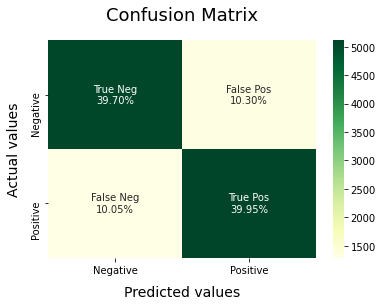

In [90]:
lg = LogisticRegression()
lg.fit(X_train, y_train)
model_Evaluate(lg)

**Observation**

- <font color=green>Performs quite good in detecting the True Positives and True Negatives.
- This Model did not overfit or underfit.</font>
- Can be concluded to be one of the best choice when it comes to binary classification using Word2Vec.

### Linear Support Vector Classification.

Similar to SVC with parameter kernel=’linear’, but implemented in terms of liblinear rather than libsvm, so it has more flexibility in the choice of penalties and loss functions and should scale better to large numbers of samples.

This class supports both dense and sparse input and the multiclass support is handled according to a one-vs-the-rest scheme.

To read more: https://www.kaggle.com/xingewang/the-math-behind-linear-svc-classifier

Accuracy of model on training data : 80.21484375
Accuracy of model on testing data : 79.6875 

              precision    recall  f1-score   support

           0       0.80      0.79      0.80      6400
           1       0.79      0.80      0.80      6400

    accuracy                           0.80     12800
   macro avg       0.80      0.80      0.80     12800
weighted avg       0.80      0.80      0.80     12800

[[5071 1329]
 [1271 5129]]


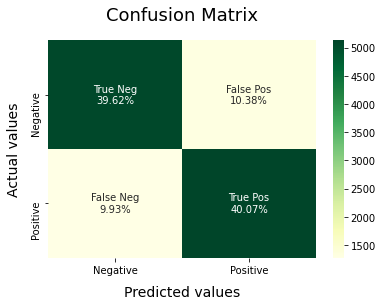

In [91]:
svm = LinearSVC()
svm.fit(X_train, y_train)
model_Evaluate(svm)

**Observation**

- <font color=green>Performs quite good in detecting the True Positives and True Negatives.</font>
- <font color=green>This Model did not overfit or underfit.</font>
- <font color=green>This Model works significantly better with Word2Vec.</font>
- Definitely a true competitor of Logistic Regression.

### Random Forest Classifier.

A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. The sub-sample size is controlled with the max_samples parameter if bootstrap=True (default), otherwise the whole dataset is used to build each tree.

Accuracy of model on training data : 99.986328125
Accuracy of model on testing data : 76.03125 

              precision    recall  f1-score   support

           0       0.76      0.77      0.76      6400
           1       0.77      0.75      0.76      6400

    accuracy                           0.76     12800
   macro avg       0.76      0.76      0.76     12800
weighted avg       0.76      0.76      0.76     12800

[[4923 1477]
 [1591 4809]]


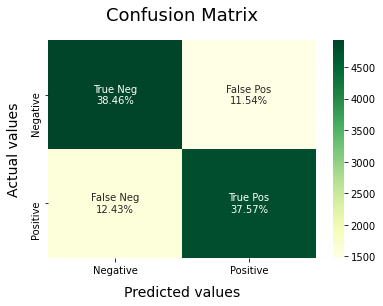

In [105]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
model_Evaluate(rf)

**Observation**

- <font color=orange>Does not perform too good in detecting the True Positives and True Negatives.</font>
- <font color=red>This Model has a high tendency to overfit.</font>

### Naive Bayes

In statistics, naive Bayes classifiers are a family of simple "probabilistic classifiers" based on applying Bayes' theorem with strong (naïve) independence assumptions between the features (see Bayes classifier). They are among the simplest Bayesian network models, but coupled with kernel density estimation, they can achieve higher accuracy levels.

Accuracy of model on training data : 69.140625
Accuracy of model on testing data : 69.4140625 

              precision    recall  f1-score   support

           0       0.69      0.70      0.69      6400
           1       0.70      0.69      0.69      6400

    accuracy                           0.69     12800
   macro avg       0.69      0.69      0.69     12800
weighted avg       0.69      0.69      0.69     12800

[[4457 1943]
 [1972 4428]]


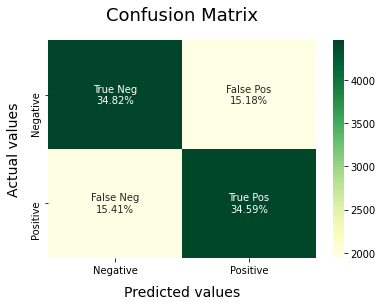

In [93]:
nb = BernoulliNB()
nb.fit(X_train, y_train)
model_Evaluate(nb)

**Observation**

- <font color='green'>This Model does not overfit or underfit.</font>
- <font color='red'>Poor performance when compared to other models, but may gain higher accuracy if coupled with kernel density estimation.</font>


**Multinomial Naive Bayes** does not support negative values so this is not appicable here.

**Note: For testing on your own reviews or to save the model, please refer to Part 1 of the notebook.**

### Future Work

- Training using RNN (Deep Learning).
- Trying to handle sarcastic reviews.
- Trying to resolve overfitting, which we found in some models.
- Trying sentiment analysis on multiple class (for example Positive, Neutral, Negative).